In [72]:
# Importing the required libraries
import os
import pandas as pd
from lxml import etree
from bs4 import BeautifulSoup
from tqdm import tqdm
tqdm.pandas()
import multiprocessing as mp
from multiprocessing import Pool
import re
import numpy as np
from tqdm import tqdm
import seaborn as sns
import nltk

### Import the Article Datasets

In [76]:
# dataset_name = 'Covid-news-top-sources'
# dataset_name = 'Covid-data-reports'
# dataset_name = 'commentary_and_editorial'
# dataset_name = 'oct_to_april_30'
# dataset_name = 'big-five-news-and-commentary'
# dataset_name = 'Covid-data-reports'
dataset_name = 'NS_sep_dec2020'

dataset_prefix = '/home/ec2-user/SageMaker/data/'
articles = os.listdir(dataset_prefix + dataset_name + '/')
corpus_directory = dataset_prefix


In [77]:
# Define a function to get the text content that is needed from the XML articles available in the dataset
def getxmlcontent(root):
    if root.find('.//HiddenText') is not None:
        return(root.find('.//HiddenText').text)
    elif root.find('.//Text') is not None:
        return(root.find('.//Text').text)
    else:
        return None


In [78]:
# Extract the necessary goid, text, and date content from the XML files
# Set up for multiprocessing--for a single file
def make_lists(article):
    try:
        tree = etree.parse(corpus_directory + dataset_name + '/' + article)
        root = tree.getroot()
        if getxmlcontent(root):
            soup = BeautifulSoup(getxmlcontent(root))
            text = soup.get_text().replace('\\n', '\n')
        else:
            text = 'Error in processing document'
        date = root.find('.//NumericDate').text
        publication = root.find('.//SortTitle').text
        title = root.find('.//Title').text
        language = root.find('.//RawLang').text
    except AttributeError:
        # Error logging - will show filename if there is a problem processing it
        print("Attribute Error" + article)
    return article, date, publication, title, text, language


In [79]:
# Check core count
num_cores = mp.cpu_count()
print(num_cores)


4


In [80]:
# When using multiple processes, important to eventually close them to avoid memory/resource leaks
try:
    # Define a thread Pool to process multiple XML files simultaneously
    # Default set to num_cores - 1, but may change number of processes depending on instance
    p = Pool(processes=num_cores-1)

    # Apply function with Pool to corpus
    processed_lists = p.map(make_lists, articles[:])
except:
    print("Error in processing document")
finally:
    p.close()


In [81]:
# Transform processed data into a dataframe
df = pd.DataFrame(processed_lists, columns=[
                  'article_id', 'date', 'publisher', 'title', 'text', 'language'])
print(len(df))
df = df[df.text != 'Error in processing document']
print(len(df))


491113
482439


In [82]:
df.date.max()


'2020-12-31'

**This dataframe contains all of the dates**

In [83]:
# df_name = 'B5_sep-mar2022.csv'
# df_name = 'corona_news_sep-mar2022.csv'
# df_name = 'B5_jan-dec2021.csv'

# df_name = 'NS_jan-dec2021.csv'
df_name = 'NS_sep-dec2020.csv'


In [84]:
# Saves the dataframe so I don't need to rescrape XML files.
df.to_csv('csv/' + df_name)


In [85]:
# df_name = 'com_editorial.csv'
# df_name = 'NS_oct-apr.csv'


In [3]:
df = pd.read_csv('csv/' + df_name)


### Create Dataframe and filter text/articles

In [86]:
df.text


0         TV Listings\nCOLLEGE FOOTBALL\n6:30 p.m.\nESPN...
1         \nMore than 200,000 dead since March. Cities i...
2         A YouTuber was detained after he filmed himsel...
3         Ohio's 2020 Ohio deer gun season will run Nov....
4         \nWe are now seven months into the pandemic, a...
                                ...                        
491108    Really!  All we want to hear is a real voice c...
491109    \n\n\n\n\n\n\nEl papa a su llegada a su audien...
491110    Wow — just wow! Thank you for supporting our p...
491111    Residents of Southwest Florida nursing homes a...
491112    A combination of events in Cascade County Dist...
Name: text, Length: 482439, dtype: object

In [87]:
def text_formatting(text):
    ''' removes new_line characters, trailing whitespaces, and reformarts some words.
    '''
    text = re.sub('\n', ' ', text).strip()
    text = re.sub('we\'ll', 'we will', text, flags=re.IGNORECASE)
    text = re.sub('didn\'t', 'did not', text, flags=re.IGNORECASE)
    text = re.sub('doesn\'t', 'does not', text, flags=re.IGNORECASE)
    text = re.sub('what\'s', 'what is', text, flags=re.IGNORECASE)
    text = re.sub('aren\'t', 'are not', text, flags=re.IGNORECASE)
    text = re.sub('haven\'t', 'have not', text, flags=re.IGNORECASE)
    text = re.sub('it\'s', 'it is', text, flags=re.IGNORECASE)
    text = re.sub('that\'s', 'that is', text, flags=re.IGNORECASE)
    text = re.sub('he\'s', 'he is', text, flags=re.IGNORECASE)
    text = re.sub('she\'s', 'she is', text, flags=re.IGNORECASE)
    text = re.sub('don\'t', 'do not', text, flags=re.IGNORECASE)
    text = re.sub(r'sars-cov-2', 'covid', text, flags=re.IGNORECASE)
    text = re.sub(r'coronavirus', 'covid', text, flags=re.IGNORECASE)
    text = re.sub(r'covid-19', 'covid', text, flags=re.IGNORECASE)
    return text


covid_keywords = ['covid', 'vaccine', 'corona', 'virus', 'variant', 'vaccination', 'vaccinated',
                  'hospital', 'cdc', 'lockdown', 'omicron', 'delta', 'ventilator', 'booster',
                  'infected', 'masks', 'cases', 'n95', 'omicron']


In [88]:
df.text = df.text.progress_apply(lambda x: text_formatting(x))


100%|██████████| 482439/482439 [06:43<00:00, 1196.33it/s]


In [89]:
df['keyword_found'] = df.text.progress_apply(lambda x: re.findall(
    r"(?=("+'|'.join(covid_keywords)+r"))", x, flags=re.IGNORECASE))
df['text_len'] = df.text.apply(len)
df['keyword_len'] = df.keyword_found.apply(len)


100%|██████████| 482439/482439 [09:49<00:00, 818.94it/s]


/home/ec2-user/SageMaker/.conda/envs/corona/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


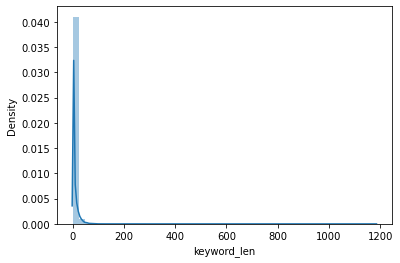

In [90]:
sns.distplot(df.keyword_len)


In [91]:
np.mean(df.text_len)


3936.26744521069

In [92]:
df = df[((df.keyword_len >= 7) & (df.text_len < 3500))
        | ((df.keyword_len >= 40) & (df.text_len > 50000))
        | ((df.keyword_len > 26) & (df.text_len > 10000))
        | ((df.keyword_len >= 15) & (df.text_len <= 10000))
        | ((df.keyword_len >= 10) & (df.text_len < 5000))]


In [93]:
def must_contain(lst):
    if len(re.findall(r'omicron', lst, flags=re.IGNORECASE)) >= 1:
        return True
    elif len(re.findall(r'covid', lst, flags=re.IGNORECASE)) >= 2:
        return True
    elif len(re.findall(r'delta', lst, flags=re.IGNORECASE)) >= 2:
        return True
    else:
        return False


In [94]:
# Uses keyword list and checks if they meet the treshold to be kept based on the three keywords above.
length_before_remov = len(df)
df = df[df.keyword_found.apply(lambda x: must_contain(' '.join(x)))]
print(
    f'Number of articles that did not meet keyword criteria: {length_before_remov - len(df)}')
print(f'Number of unique articles: {df.article_id.nunique()}')


Number of articles that did not meet keyword criteria: 2145
Number of unique articles: 40012


In [95]:
# Few bad articles found.
drop_list = ['2451579018.xml', '2476387095.xml', '2488007259.xml', '2541478987.xml', '2580382669.xml', '2619769756.xml',
             '2580683381.xml', '2458469193.xml', '2462711503.xml', '2610314222.xml']
df.drop(df[df.article_id.isin(drop_list)].index, axis=0, inplace=True)


Some basic sentence formatting and choosing the number of sentences to keep

In [96]:
def period_spacing_formatting(text):
    text = re.sub('(?<=\.)(?=[A-Z]\B)', ' ', text)
    return text


df['text'] = df.text.progress_apply(lambda x: period_spacing_formatting(x))
sent_tokenizer = nltk.data.load('nltk_tokenizer/punkt/english.pickle')
df['sentences'] = df.text.progress_apply(lambda x: sent_tokenizer.tokenize(x))


def sentences_keep(sentences):
    if len(sentences) > 13:
        return sentences[:13]
    elif (len(sentences) <= 13) & (len(sentences) > 1):
        return sentences[:-1]
    else:
        return sentences


# Keep only the first 13 sentences.
df.sentences = df.sentences.apply(lambda x: sentences_keep(x))
df.drop('text', axis=1, inplace=True)
df.drop('keyword_found', axis=1, inplace=True)


def keep_pairs(lst):
    """ Makes predictions on pairs of sentences since they are usually small enough and fixes issues of tiny sentences.
    """
    return [' '.join(x) for x in zip(lst[0::2], lst[1::2])]


df['pairs'] = df.sentences.apply(keep_pairs)
df.reset_index(inplace=True, drop=True)


100%|██████████| 40010/40010 [00:41<00:00, 966.47it/s] 


**Need to remove all columns but 3**

In [97]:
pre_explode = df[['date', 'article_id', 'title']]


In [98]:
pre_explode.head()


,date,article_id,title
0,2020-11-23,2462862453.xml,Thanksgiving in the shadow of a pandemic
1,2020-10-27,2454312897.xml,State plan for vaccine distribution forming
2,2020-10-26,2458556314.xml,Hoop dreams on hold for former area standouts
3,2020-10-13,2604155275.xml,County reports 31 new COVID-19 cases
4,2020-11-19,2461859791.xml,Grassley tests positive for virus


In [99]:
print(df_name)
# THIS HAS THE DATE MERGE DATA.
pre_explode.to_csv('csv/pre_explode_' + df_name)


NS_sep-dec2020.csv


**Need to save the article i.ds of the ones being used so I can remove duplicates from the News Wire database.**

**Make sure to concatenate all the other files other than the first one**

In [100]:
# np.save(file='duplicates.npy', arr=df.article_id.unique())
# duplicates = np.load(file='duplicates.npy', allow_pickle=True)
# updated_duplicate = np.concatenate((duplicates, df.article_id))
# np.save(file='duplicates', arr=updated_duplicate)
check = np.load(file='duplicates.npy', allow_pickle=True)
df.article_id.isin(check).sum()


5285

In [101]:
df = df[~df.article_id.isin(check)]


In [102]:
# This keeps it in the format required for data loader.
df = df.explode('pairs')
df.reset_index(inplace=True, drop=True)


In [103]:
print(f'Dataframe {df_name} goes from {df.date.min()} to {df.date.max()}.')
print(f'Dataframe {df_name} has {df.article_id.nunique()} unique articles.')


Dataframe NS_sep-dec2020.csv goes from 2020-09-01 to 2020-12-31.
Dataframe NS_sep-dec2020.csv has 34725 unique articles.


In [104]:
df.to_csv('csv/no_txt_' + df_name)


In [105]:
df_name


'NS_sep-dec2020.csv'

In [106]:
# df.sample(100).to_csv('email_test/tdm_samples.csv')


In [ ]:
re.